In [83]:
import os
import gc
import cv2
import math
import copy
import time
import random
import shutil, sys    
from PIL import Image
import glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import f1_score,roc_auc_score
import timm
from timm.models.efficientnet import *
import joblib
from tqdm import tqdm
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from scipy import ndimage

In [ ]:
def autocropmin(image, threshold=100, kernsel_size = 10):
        
    img = image.copy()
    area=img.shape[0]*img.shape[1]
    SIZE = img.shape[0]
    imgfilt = ndimage.minimum_filter(img, size=kernsel_size)
    img_b=np.where(imgfilt<threshold,0,255)
    a=img_b[:,:,0].sum(axis=1)
    a=np.concatenate(([0],a,[0]))
    a_=np.where(a==0)[0]
    mina=a_[np.argmax(a_[1:]-a_[:-1])]
    maxa=a_[np.argmax(a_[1:]-a_[:-1])+1]-1
    b=img_b[:,:,0].sum(axis=0)
    b=np.concatenate(([0],b,[0]))
    b_=np.where(b==0)[0]
    minb=b_[np.argmax(b_[1:]-b_[:-1])]
    maxb=b_[np.argmax(b_[1:]-b_[:-1])+1]-1

    if  mina!=maxa and minb!=maxb:
        imageout=img[mina:maxa,minb:maxb,:]
    else:
        imageout=img

    return img_b

str1='/ssd2/ming/2024COVID/train/negative/ct_scan_14/74.jpg'
img=cv2.imread(str1)
cropped_image = autocropmin(img)
print(cropped_image.shape)
#cropped_image = np.where(cropped_image > 0, 1, 0)

# Convert BGR image to RGB
#img_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)

# Display the cropped image
plt.imshow(cropped_image, cmap='gray')  # Specify colormap as 'gray' for grayscale
plt.title('Cropped Image')
plt.axis('off')
plt.show()

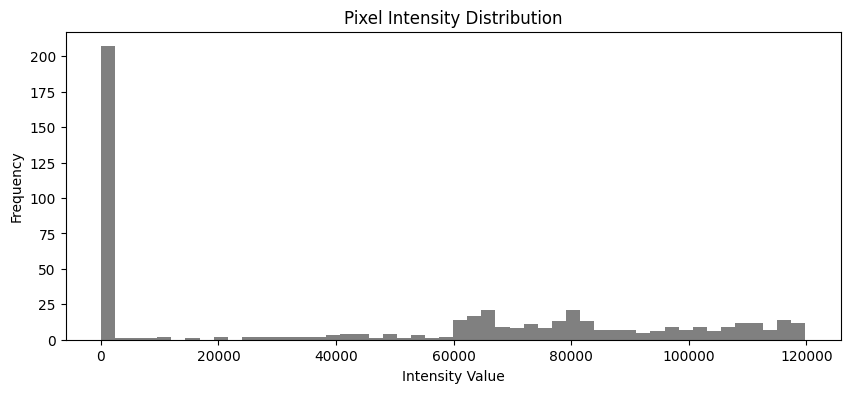

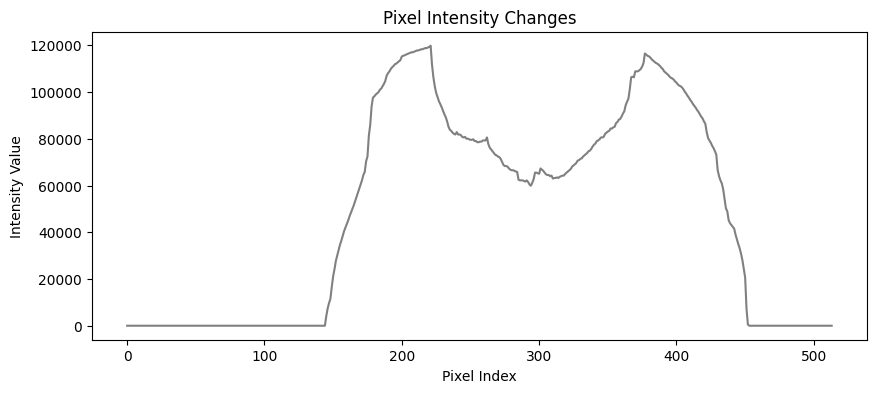

Cannot reshape array into a square for visualization.


In [106]:
# Histogram Visualization
plt.figure(figsize=(10, 4))
plt.hist(cropped_image, bins=50, color='gray')
plt.title('Pixel Intensity Distribution')
plt.xlabel('Intensity Value')
plt.ylabel('Frequency')
plt.show()

# Line Plot
plt.figure(figsize=(10, 4))
plt.plot(cropped_image, color='gray')
plt.title('Pixel Intensity Changes')
plt.xlabel('Pixel Index')
plt.ylabel('Intensity Value')
plt.show()

# If applicable: Reshape and Visualize as an Image
# This step requires knowing the intended dimensions of the 2D array
# Here's an example assuming a square shape for simplicity
side_length = int(np.sqrt(len(cropped_image)))
if side_length ** 2 == len(cropped_image):  # Check if it's possible to reshape into a square
    img_2d = cropped_image.reshape((side_length, side_length))
    plt.figure(figsize=(6, 6))
    plt.imshow(img_2d, cmap='gray')
    plt.title('2D Image Visualization')
    plt.axis('off')  # Hide axis
    plt.show()
else:
    print("Cannot reshape array into a square for visualization.")

In [5]:
train_df_list_ = pd.read_csv("/ssd2/ming/2024COVID/chih_4_fold_covid_train_df.csv") #使用已經切割好fold index的影像資訊彙整檔案
valid_df_list_ = pd.read_csv("/ssd2/ming/2024COVID/chih_4_fold_covid_valid_df.csv") #使用已經切割好fold index的影像資訊彙整檔案

# %%
#drop_train_df_list_ = train_df_list_.drop_duplicates(subset='token_key')
drop_valid_df_list_ = valid_df_list_.drop_duplicates(subset='token_key')
all_train_list=[list(glob.glob(os.path.join("/ssd2/ming/2024COVID/train/positive", "*"))),
                list(glob.glob(os.path.join("/ssd2/ming/2024COVID/train/negative", "*"))),
                list(glob.glob(os.path.join("/ssd2/ming/2024COVID/valid/positive", "*"))),
                list(glob.glob(os.path.join("/ssd2/ming/2024COVID/valid/negative", "*")))]


In [ ]:
# 初始化一个列表来收集数据
data_to_save = []

for train_list in all_train_list:
    diff_shape_ct_list = []
    
    for i in tqdm(range(len(train_list))):
        tmp_list=list(glob.glob(os.path.join(train_list[i], "*")))
        tmp_shape_set=set()
        for j in range(len(tmp_list)):

            str1=tmp_list[j]
            img=cv2.imread(str1)

            try:
                tmp_shape_set.add(img.shape)
            except:
                print(str1)
                print("bug file")
                continue

            img,img1,imgout2,area,area2,save=autocropmin(img)
            data_to_save.append([str1, img1, imgout2, area, area2, save])  # 收集数据
            print([str1, img1, imgout2, area, area2, save])

            
            str1=str1.replace("/valid/","/valid_pure_crop_challenge/")
            str1=str1.replace("/train/","/train_pure_crop_challenge/")


            folder_path="/".join(str1.split("/")[:-1])

            if len(tmp_shape_set)!=1:
                shutil.rmtree(folder_path)
                diff_shape_ct_list.append(folder_path)
                
                break

            if not os.path.exists(folder_path):
                os.makedirs(folder_path)
            cv2.imwrite(str1,img)
    for ct_path in diff_shape_ct_list:
        
        str2=ct_path   
        str1=str2.replace("/valid_pure_crop_challenge/","/valid/")
        str1=str1.replace("/train_pure_crop_challenge/","/train/")

        tmp_list=list(glob.glob(os.path.join(str1, "*")))
        last_file=str(len(tmp_list)-1)+".jpg"
        str1=str1+"/"+last_file
        str2=str2+"/"+last_file
        img=cv2.imread(str1)
        img,img1,imgout2,area,area2,save=autocropmin(img)
        data_to_save.append([str1, img1, imgout2, area, area2, save])  # 收集数据
        print([str1, img1, imgout2, area, area2, save])
        folder_path="/".join(str2.split("/")[:-1])

        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        cv2.imwrite(str2,img)
# CSV 文件保存路径
csv_file_path = '/ssd2/ming/2024COVID/Analysis/val_output.csv'

# 将数据写入 CSV 文件
with open(csv_file_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Image Path', 'Img1', 'Imgout2', 'Area', 'Area2', 'Save'])  # 写入标题
    for row in data_to_save:
        writer.writerow(row)  # 写入数据行

In [7]:
csv_file_path = '/ssd2/ming/2024COVID/Analysis/train_val_output.csv'
import csv
# 将数据写入 CSV 文件
with open(csv_file_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Image Path', 'Img1', 'Imgout2', 'Area', 'Area2', 'Save'])  # 写入标题
    for row in data_to_save:
        writer.writerow(row)  # 写入数据行

In [51]:
csv_file_path = '/ssd2/ming/2024COVID/Analysis/train_negative.csv'
train_negative=pd.read_csv(csv_file_path)


csv_file_path = '/ssd2/ming/2024COVID/Analysis/train_positive.csv'
train_positive=pd.read_csv(csv_file_path)


data_to_save=pd.concat([train_positive,train_negative])

data_to_save
csv_file_path = '/ssd2/ming/2024COVID/Analysis/valid_negative.csv'
valid_negative=pd.read_csv(csv_file_path)

data_to_save=pd.concat([data_to_save,valid_negative])

csv_file_path = '/ssd2/ming/2024COVID/Analysis/valid_positive.csv'
valid_positive=pd.read_csv(csv_file_path)
data_to_save=pd.concat([data_to_save,valid_positive])
data_to_save = data_to_save.reset_index(drop=True)

data_to_save

,Image Path,Original Size,Cropped Size,Original Area,Cropped Area,Area Ratio
0,/ssd2/ming/2024COVID/train/positive/ct_scan_60...,"(512, 512, 3)","(321, 512, 3)",262144,164352,0.373047
1,/ssd2/ming/2024COVID/train/positive/ct_scan_60...,"(512, 512, 3)","(312, 512, 3)",262144,159744,0.390625
2,/ssd2/ming/2024COVID/train/positive/ct_scan_60...,"(512, 512, 3)","(316, 512, 3)",262144,161792,0.382812
3,/ssd2/ming/2024COVID/train/positive/ct_scan_60...,"(512, 512, 3)","(355, 512, 3)",262144,181760,0.306641
4,/ssd2/ming/2024COVID/train/positive/ct_scan_60...,"(512, 512, 3)","(364, 512, 3)",262144,186368,0.289062
...,...,...,...,...,...,...
475046,/ssd2/ming/2024COVID/valid/positive/ct_scan_46...,"(288, 478, 3)","(288, 478, 3)",137664,137664,0.000000
475047,/ssd2/ming/2024COVID/valid/positive/ct_scan_10...,"(278, 484, 3)","(278, 484, 3)",134552,134552,0.000000
475048,/ssd2/ming/2024COVID/valid/positive/ct_scan_18...,"(288, 478, 3)","(288, 478, 3)",137664,137664,0.000000
475049,/ssd2/ming/2024COVID/valid/positive/ct_scan_48...,"(296, 474, 3)","(296, 474, 3)",140304,140304,0.000000


In [ ]:
data_to_save = data_to_save.values.tolist()
data_to_save

In [ ]:

# 分类数据
categories = {
    'train/positive': [],
    'train/negative': [],
    'valid/positive': [],
    'valid/negative': [],
    'positive':[],
    'negative':[]
}

# 遍历并分类
for item in data_to_save:
    print(item[0])
    if 'train/positive' in item[0]:
        categories['train/positive'].append(item)
    elif 'train/negative' in item[0]:
        categories['train/negative'].append(item)
    elif 'valid/positive' in item[0]:
        categories['valid/positive'].append(item)
    elif 'valid/negative' in item[0]:
        categories['valid/negative'].append(item)
for item in data_to_save:
    if 'positive' in item[0]:
        categories['positive'].append(item)
    elif 'negative' in item[0]:
        categories['negative'].append(item)
#for category, items in categories.items():
#    with open(f'/ssd2/ming/2024COVID/Analysis/{category.replace("/", "_")}.csv', 'w', newline='') as file:
#        writer = csv.writer(file)
#        writer.writerow(['Image Path', 'Original Size', 'Cropped Size', 'Original Area', 'Cropped Area', 'Area Ratio'])
#        for row in items:
#            writer.writerow(row)

In [72]:
# 提取所有的 Area Ratio 值

print(len(data_to_save))
area_ratios = [item[-1] for item in data_to_save]
Cropped_Area = [item[-2] for item in data_to_save]
Original_Area = [item[-3] for item in data_to_save]
# 计算平均值
average_area_ratio = sum(area_ratios) / len(area_ratios)
remain_area = sum(Cropped_Area) / len(area_ratios)
original_area = sum(Original_Area) / len(area_ratios)
Cropped_area = (sum(Original_Area) - sum(Cropped_Area)) / len(area_ratios)
print(f"Average Area Ratio: {average_area_ratio}")
print(f"Original_area: {original_area}")
print(f"Remain_area: {remain_area}")
print(f"Cropped_area: {Cropped_area}")


475051
Average Area Ratio: 0.41825011897530523
Original_area: 266946.1560885042
Remain_area: 155474.29288644798
Cropped_area: 111471.8632020562


In [55]:
print(len(categories['train/positive']))
# 提取所有的 Area Ratio 值
area_ratios = [item[-1] for item in  categories['train/positive']]
Cropped_Area = [item[-2] for item in  categories['train/positive']]
Original_Area = [item[-3] for item in  categories['train/positive']]
# 计算平均值
average_area_ratio = sum(area_ratios) / len(area_ratios)
remain_area = sum(Cropped_Area) / len(area_ratios)
original_area = sum(Original_Area) / len(area_ratios)
Cropped_area = (sum(Original_Area) - sum(Cropped_Area)) / len(area_ratios)
print(f"Average Area Ratio: {average_area_ratio}")
print(f"Original_area: {original_area}")
print(f"Remain_area: {remain_area}")
print(f"Cropped_area: {Cropped_area}")
print(len(area_ratios))

206608
Average Area Ratio: 0.40885159406543303
Original_area: 266423.92255866184
Remain_area: 157690.2143576241
Cropped_area: 108733.70820103772
206608


In [ ]:
print(len(categories['train/negative']))
# 提取所有的 Area Ratio 值
area_ratios = [item[-1] for item in  categories['train/negative']]
Cropped_Area = [item[-2] for item in  categories['train/negative']]
Original_Area = [item[-3] for item in  categories['train/negative']]
# 计算平均值
average_area_ratio = sum(area_ratios) / len(area_ratios)
remain_area = sum(Cropped_Area) / len(area_ratios)
original_area = sum(Original_Area) / len(area_ratios)
Cropped_area = (sum(Original_Area) - sum(Cropped_Area)) / len(area_ratios)
print(f"Average Area Ratio: {average_area_ratio}")
print(f"Original_area: {original_area}")
print(f"Remain_area: {remain_area}")
print(f"Cropped_area: {Cropped_area}")

178722
Average Area Ratio: 0.4296222157234287
Original_area: 268212.7737827464
Remain_area: 153033.16137352985
Cropped_area: 115179.61240921656


In [ ]:
print(len(categories['valid/positive']))

# 提取所有的 Area Ratio 值
area_ratios = [item[-1] for item in  categories['valid/positive']]
Cropped_Area = [item[-2] for item in  categories['valid/positive']]
Original_Area = [item[-3] for item in  categories['valid/positive']]
# 计算平均值
average_area_ratio = sum(area_ratios) / len(area_ratios)
remain_area = sum(Cropped_Area) / len(area_ratios)
original_area = sum(Original_Area) / len(area_ratios)
Cropped_area = (sum(Original_Area) - sum(Cropped_Area)) / len(area_ratios)
print(f"Average Area Ratio: {average_area_ratio}")
print(f"Original_area: {original_area}")
print(f"Remain_area: {remain_area}")
print(f"Cropped_area: {Cropped_area}")

Average Area Ratio: 0.4061960493630662
Original_area: 268948.1508188176
Remain_area: 160489.26942791365
Cropped_area: 108458.88139090396


In [ ]:
print(len(categories['valid/negative']))

# 提取所有的 Area Ratio 值
area_ratios = [item[-1] for item in  categories['valid/negative']]
Cropped_Area = [item[-2] for item in  categories['valid/negative']]
Original_Area = [item[-3] for item in  categories['valid/negative']]
# 计算平均值
average_area_ratio = sum(area_ratios) / len(area_ratios)
remain_area = sum(Cropped_Area) / len(area_ratios)
original_area = sum(Original_Area) / len(area_ratios)
Cropped_area = (sum(Original_Area) - sum(Cropped_Area)) / len(area_ratios)
print(f"Average Area Ratio: {average_area_ratio}")
print(f"Original_area: {original_area}")
print(f"Remain_area: {remain_area}")
print(f"Cropped_area: {Cropped_area}")

43679
Average Area Ratio: 0.4288813154918866
Original_area: 262123.457222006
Remain_area: 149694.79365370085
Cropped_area: 112428.66356830513


In [ ]:
print(len(categories['valid/negative']+categories['valid/positive']))
# 提取所有的 Area Ratio 值
area_ratios = [item[-1] for item in  categories['valid/negative']+categories['valid/positive']]
Cropped_Area = [item[-2] for item in  categories['valid/negative']+categories['valid/positive']]
Original_Area = [item[-3] for item in  categories['valid/negative']+categories['valid/positive']]
# 计算平均值
average_area_ratio = sum(area_ratios) / len(area_ratios)
remain_area = sum(Cropped_Area) / len(area_ratios)
original_area = sum(Original_Area) / len(area_ratios)
Cropped_area = (sum(Original_Area) - sum(Cropped_Area)) / len(area_ratios)
print(f"Average Area Ratio: {average_area_ratio}")
print(f"Original_area: {original_area}")
print(f"Remain_area: {remain_area}")
print(f"Cropped_area: {Cropped_area}")

89721
Average Area Ratio: 0.4172399492219705
Original_area: 265625.67568350775
Remain_area: 155234.17967922782
Cropped_area: 110391.49600427994


In [ ]:
print(len(categories['train/negative']+categories['train/positive']))

# 提取所有的 Area Ratio 值
area_ratios = [item[-1] for item in  categories['train/negative']+categories['train/positive']]
Cropped_Area = [item[-2] for item in  categories['train/negative']+categories['train/positive']]
Original_Area = [item[-3] for item in  categories['train/negative']+categories['train/positive']]
# 计算平均值
average_area_ratio = sum(area_ratios) / len(area_ratios)
remain_area = sum(Cropped_Area) / len(area_ratios)
original_area = sum(Original_Area) / len(area_ratios)
Cropped_area = (sum(Original_Area) - sum(Cropped_Area)) / len(area_ratios)
print(f"Average Area Ratio: {average_area_ratio}")
print(f"Original_area: {original_area}")
print(f"Remain_area: {remain_area}")
print(f"Cropped_area: {Cropped_area}")

385330
Average Area Ratio: 0.4184853289004059
Original_area: 267253.61936002906
Remain_area: 155530.2013209457
Cropped_area: 111723.41803908338


In [58]:
print(len(categories['negative']))
# 提取所有的 Area Ratio 值
area_ratios = [item[-1] for item in  categories['negative']]
Cropped_Area = [item[-2] for item in  categories['negative']]
Original_Area = [item[-3] for item in  categories['negative']]
# 计算平均值
average_area_ratio = sum(area_ratios) / len(area_ratios)
remain_area = sum(Cropped_Area) / len(area_ratios)
original_area = sum(Original_Area) / len(area_ratios)
Cropped_area = (sum(Original_Area) - sum(Cropped_Area)) / len(area_ratios)
print(f"Average Area Ratio: {average_area_ratio}")
print(f"Original_area: {original_area}")
print(f"Remain_area: {remain_area}")
print(f"Cropped_area: {Cropped_area}")
print(len(area_ratios))

222401
Average Area Ratio: 0.4294767047715286
Original_area: 267016.84724439186
Remain_area: 152377.51430524144
Cropped_area: 114639.33293915045
222401


In [57]:
print(len(categories['positive']))
# 提取所有的 Area Ratio 值
area_ratios = [item[-1] for item in  categories['positive']]
Cropped_Area = [item[-2] for item in  categories['positive']]
Original_Area = [item[-3] for item in  categories['positive']]
# 计算平均值
average_area_ratio = sum(area_ratios) / len(area_ratios)
remain_area = sum(Cropped_Area) / len(area_ratios)
original_area = sum(Original_Area) / len(area_ratios)
Cropped_area = (sum(Original_Area) - sum(Cropped_Area)) / len(area_ratios)
print(f"Average Area Ratio: {average_area_ratio}")
print(f"Original_area: {original_area}")
print(f"Remain_area: {remain_area}")
print(f"Cropped_area: {Cropped_area}")
print(len(area_ratios))

252650
Average Area Ratio: 0.40836765743694886
Original_area: 266883.9285652088
Remain_area: 158200.30378389076
Cropped_area: 108683.62478131802
252650


In [59]:
import pickle
with open('/ssd2/ming/2024COVID/filter_slice_train_dic1_05_challenge.pickle', 'rb') as f:
    train_dic = pickle.load(f)

with open('/ssd2/ming/2024COVID/filter_slice_valid_dic1_05_challenge.pickle', 'rb') as f:
    valid_dlc = pickle.load(f)
    

In [60]:
print(len(train_dic))
print(len(valid_dlc))

1349
318


In [61]:
array_data = list(train_dic)
array_data2 = list(train_dic.values())
difference_list = [pair[1] - pair[0] for pair in array_data2]
data_combined = [[array_data[i]] + [difference_list[i]] + [array_data2[i]]for i in range(len(array_data))]

df_train = pd.DataFrame(data_combined, columns=['File Path', 'difference', 'interval'])
df_train

,File Path,difference,interval
0,/ssd2/ming/2024COVID/train_pure_crop_challenge...,185,"[80, 265]"
1,/ssd2/ming/2024COVID/train_pure_crop_challenge...,209,"[112, 321]"
2,/ssd2/ming/2024COVID/train_pure_crop_challenge...,30,"[11, 41]"
3,/ssd2/ming/2024COVID/train_pure_crop_challenge...,262,"[79, 341]"
4,/ssd2/ming/2024COVID/train_pure_crop_challenge...,28,"[10, 38]"
...,...,...,...
1344,/ssd2/ming/2024COVID/train_pure_crop_challenge...,172,"[81, 253]"
1345,/ssd2/ming/2024COVID/train_pure_crop_challenge...,27,"[12, 39]"
1346,/ssd2/ming/2024COVID/train_pure_crop_challenge...,257,"[119, 376]"
1347,/ssd2/ming/2024COVID/train_pure_crop_challenge...,195,"[84, 279]"


In [62]:
array_data = list(valid_dlc)
array_data2 = list(valid_dlc.values())
difference_list = [pair[1] - pair[0] for pair in array_data2]
data_combined = [[array_data[i]] + [difference_list[i]] + [array_data2[i]]for i in range(len(array_data))]

df_val = pd.DataFrame(data_combined, columns=['File Path', 'difference', 'interval'])
df_val

,File Path,difference,interval
0,/ssd2/ming/2024COVID/valid_pure_crop_challenge...,229,"[81, 310]"
1,/ssd2/ming/2024COVID/valid_pure_crop_challenge...,150,"[66, 216]"
2,/ssd2/ming/2024COVID/valid_pure_crop_challenge...,201,"[91, 292]"
3,/ssd2/ming/2024COVID/valid_pure_crop_challenge...,141,"[74, 215]"
4,/ssd2/ming/2024COVID/valid_pure_crop_challenge...,168,"[59, 227]"
...,...,...,...
313,/ssd2/ming/2024COVID/valid_pure_crop_challenge...,31,"[10, 41]"
314,/ssd2/ming/2024COVID/valid_pure_crop_challenge...,195,"[105, 300]"
315,/ssd2/ming/2024COVID/valid_pure_crop_challenge...,31,"[14, 45]"
316,/ssd2/ming/2024COVID/valid_pure_crop_challenge...,170,"[36, 206]"


In [63]:
df_filtered = pd.concat([df_train,df_val])
df_filtered

,File Path,difference,interval
0,/ssd2/ming/2024COVID/train_pure_crop_challenge...,185,"[80, 265]"
1,/ssd2/ming/2024COVID/train_pure_crop_challenge...,209,"[112, 321]"
2,/ssd2/ming/2024COVID/train_pure_crop_challenge...,30,"[11, 41]"
3,/ssd2/ming/2024COVID/train_pure_crop_challenge...,262,"[79, 341]"
4,/ssd2/ming/2024COVID/train_pure_crop_challenge...,28,"[10, 38]"
...,...,...,...
313,/ssd2/ming/2024COVID/valid_pure_crop_challenge...,31,"[10, 41]"
314,/ssd2/ming/2024COVID/valid_pure_crop_challenge...,195,"[105, 300]"
315,/ssd2/ming/2024COVID/valid_pure_crop_challenge...,31,"[14, 45]"
316,/ssd2/ming/2024COVID/valid_pure_crop_challenge...,170,"[36, 206]"


In [64]:
# 初始化一个列表来收集数据
data_length_save = []

for train_list in all_train_list:
    diff_shape_ct_list = []
    
    for i in tqdm(range(len(train_list))):
        tmp_list=list(glob.glob(os.path.join(train_list[i], "*")))
        tmp_shape_set=set()
        #print(len(tmp_list))
        path = os.path.join(train_list[i])
        path=path.replace("/valid/","/valid_pure_crop_challenge/")
        path=path.replace("/train/","/train_pure_crop_challenge/")
        data_length_save.append([path,len(tmp_list),[0,len(tmp_list)-1]])
        

# CSV 文件保存路径
csv_file_path = '/ssd2/ming/2024COVID/Analysis/data_length_save.csv'

# 将数据写入 CSV 文件
with open(csv_file_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Slice Path', 'length', 'from', 'to'])  # 写入标题
    for row in data_to_save:
        writer.writerow(row)  # 写入数据行

100%|██████████| 156/156 [00:00<00:00, 2358.01it/s]


In [65]:
data_length_save

df_og = pd.DataFrame(data_length_save, columns=['File Path', 'difference', 'interval'])
df_og

,File Path,difference,interval
0,/ssd2/ming/2024COVID/train_pure_crop_challenge...,44,"[0, 43]"
1,/ssd2/ming/2024COVID/train_pure_crop_challenge...,59,"[0, 58]"
2,/ssd2/ming/2024COVID/train_pure_crop_challenge...,232,"[0, 231]"
3,/ssd2/ming/2024COVID/train_pure_crop_challenge...,52,"[0, 51]"
4,/ssd2/ming/2024COVID/train_pure_crop_challenge...,55,"[0, 54]"
...,...,...,...
1679,/ssd2/ming/2024COVID/valid_pure_crop_challenge...,51,"[0, 50]"
1680,/ssd2/ming/2024COVID/valid_pure_crop_challenge...,197,"[0, 196]"
1681,/ssd2/ming/2024COVID/valid_pure_crop_challenge...,52,"[0, 51]"
1682,/ssd2/ming/2024COVID/valid_pure_crop_challenge...,397,"[0, 396]"


In [81]:
df_merge

,File Path,difference_x,interval_x,difference_y,interval_y
0,/ssd2/ming/2024COVID/train_pure_crop_challenge...,44,"[0, 43]",22,"[10, 32]"
1,/ssd2/ming/2024COVID/train_pure_crop_challenge...,59,"[0, 58]",30,"[11, 41]"
2,/ssd2/ming/2024COVID/train_pure_crop_challenge...,232,"[0, 231]",116,"[59, 175]"
3,/ssd2/ming/2024COVID/train_pure_crop_challenge...,52,"[0, 51]",26,"[13, 39]"
4,/ssd2/ming/2024COVID/train_pure_crop_challenge...,55,"[0, 54]",28,"[14, 42]"
...,...,...,...,...,...
1662,/ssd2/ming/2024COVID/valid_pure_crop_challenge...,51,"[0, 50]",26,"[8, 34]"
1663,/ssd2/ming/2024COVID/valid_pure_crop_challenge...,197,"[0, 196]",99,"[77, 176]"
1664,/ssd2/ming/2024COVID/valid_pure_crop_challenge...,52,"[0, 51]",26,"[15, 41]"
1665,/ssd2/ming/2024COVID/valid_pure_crop_challenge...,397,"[0, 396]",199,"[108, 307]"


In [82]:

df_merge = pd.merge(df_og, df_filtered, on='File Path')
print(sum(df_merge['difference_x'])/1667)


284.6832633473305


In [68]:
def calculate_averages_fixed(df):
    # Helper function to extract category from the file path
    def extract_category(file_path):
        # Initialize category as an empty string
        category = ''

        # Check for 'train' or 'valid' in the file path
        if 'train' in file_path:
            category = 'train'
        elif 'valid' in file_path:
            category = 'valid'

        # Check for 'positive' or 'negative' in the file path
        if 'positive' in file_path:
            category += '_positive'
        elif 'negative' in file_path:
            category += '_negative'

        return category
    # Adding a new column for category
    df['Category'] = df['File Path'].apply(extract_category)
    # Calculating the difference ratio
    df['Diff Ratio'] = (df['difference_x'] - df['difference_y']) / df['difference_x']

    # Grouping by category and calculating averages
    averages = df.groupby('Category').agg(
        Average_Difference_X=pd.NamedAgg(column='difference_x', aggfunc='mean'),
        Average_Difference_Y=pd.NamedAgg(column='difference_y', aggfunc='mean'),
        Average_Diff_Ratio=pd.NamedAgg(column='Diff Ratio', aggfunc='mean')
    )

    # Calculating averages for 'total' category
    total_averages = pd.DataFrame(df.agg(
        Average_Difference_X=('difference_x', 'mean'),
        Average_Difference_Y=('difference_y', 'mean'),
        Average_Diff_Ratio=('Diff Ratio', 'mean')
    )).transpose()
    #total_averages.index = ['total']

    # Concatenating the group averages with the total averages
    #all_averages = pd.concat([averages, total_averages])

    return averages

# Assuming df is your DataFrame, you would call the function like this:
averages_df = calculate_averages_fixed(df_merge)
averages_df
# Note: Since I don't have the actual DataFrame, the function isn't executed here.
# You should execute this function in your environment with your DataFrame.


,Average_Difference_X,Average_Difference_Y,Average_Diff_Ratio
Category,,,
train_negative,273.978495,137.264209,0.498196
train_positive,295.908309,148.180516,0.498523
valid_negative,283.490196,141.973856,0.498421
valid_positive,280.539394,140.551515,0.498462


In [69]:
def calculate_averages_fixed(df):
    # Helper function to extract category from the file path
    def extract_category(file_path):
        # Initialize category as an empty string
        category = ''



        # Check for 'positive' or 'negative' in the file path
        if 'positive' in file_path:
            category += 'positive'
        elif 'negative' in file_path:
            category += 'negative'

        return category
    # Adding a new column for category
    df['Category'] = df['File Path'].apply(extract_category)
    # Calculating the difference ratio
    df['Diff Ratio'] = (df['difference_x'] - df['difference_y']) / df['difference_x']

    # Grouping by category and calculating averages
    averages = df.groupby('Category').agg(
        Average_Difference_X=pd.NamedAgg(column='difference_x', aggfunc='mean'),
        Average_Difference_Y=pd.NamedAgg(column='difference_y', aggfunc='mean'),
        Average_Diff_Ratio=pd.NamedAgg(column='Diff Ratio', aggfunc='mean')
    )

    # Calculating averages for 'total' category
    total_averages = pd.DataFrame(df.agg(
        Average_Difference_X=('difference_x', 'mean'),
        Average_Difference_Y=('difference_y', 'mean'),
        Average_Diff_Ratio=('Diff Ratio', 'mean')
    )).transpose()
    #total_averages.index = ['total']

    # Concatenating the group averages with the total averages
    #all_averages = pd.concat([averages, total_averages])

    return averages

# Assuming df is your DataFrame, you would call the function like this:
averages_df = calculate_averages_fixed(df_merge)
averages_df
# Note: Since I don't have the actual DataFrame, the function isn't executed here.
# You should execute this function in your environment with your DataFrame.


,Average_Difference_X,Average_Difference_Y,Average_Diff_Ratio
Category,,,
negative,275.788557,138.160448,0.498239
positive,292.969873,146.721900,0.498511


In [70]:
def calculate_averages_fixed(df):
    # Helper function to extract category from the file path
    def extract_category(file_path):
        # Initialize category as an empty string
        category = ''

        # Check for 'train' or 'valid' in the file path
        if 'train' in file_path:
            category = 'train'
        elif 'valid' in file_path:
            category = 'valid'


        return category
    # Adding a new column for category
    df['Category'] = df['File Path'].apply(extract_category)
    # Calculating the difference ratio
    df['Diff Ratio'] = (df['difference_x'] - df['difference_y']) / df['difference_x']

    # Grouping by category and calculating averages
    averages = df.groupby('Category').agg(
        Average_Difference_X=pd.NamedAgg(column='difference_x', aggfunc='mean'),
        Average_Difference_Y=pd.NamedAgg(column='difference_y', aggfunc='mean'),
        Average_Diff_Ratio=pd.NamedAgg(column='Diff Ratio', aggfunc='mean')
    )

    # Calculating averages for 'total' category
    total_averages = pd.DataFrame(df.agg(
        Average_Difference_X=('difference_x', 'mean'),
        Average_Difference_Y=('difference_y', 'mean'),
        Average_Diff_Ratio=('Diff Ratio', 'mean')
    )).transpose()
    #total_averages.index = ['total']

    # Concatenating the group averages with the total averages
    #all_averages = pd.concat([averages, total_averages])

    return averages

# Assuming df is your DataFrame, you would call the function like this:
averages_df = calculate_averages_fixed(df_merge)
averages_df
# Note: Since I don't have the actual DataFrame, the function isn't executed here.
# You should execute this function in your environment with your DataFrame.


,Average_Difference_X,Average_Difference_Y,Average_Diff_Ratio
Category,,,
train,285.325426,142.912528,0.498365
valid,281.959119,141.235849,0.498442


In [71]:
def calculate_averages_fixed(df):
    # Helper function to extract category from the file path
    def extract_category(file_path):
        # Initialize category as an empty string
        category = ''


        return category
    # Adding a new column for category
    df['Category'] = df['File Path'].apply(extract_category)
    # Calculating the difference ratio
    df['Diff Ratio'] = (df['difference_x'] - df['difference_y']) / df['difference_x']

    # Grouping by category and calculating averages
    averages = df.groupby('Category').agg(
        Average_Difference_X=pd.NamedAgg(column='difference_x', aggfunc='mean'),
        Average_Difference_Y=pd.NamedAgg(column='difference_y', aggfunc='mean'),
        Average_Diff_Ratio=pd.NamedAgg(column='Diff Ratio', aggfunc='mean')
    )

    # Calculating averages for 'total' category
    total_averages = pd.DataFrame(df.agg(
        Average_Difference_X=('difference_x', 'mean'),
        Average_Difference_Y=('difference_y', 'mean'),
        Average_Diff_Ratio=('Diff Ratio', 'mean')
    )).transpose()
    #total_averages.index = ['total']

    # Concatenating the group averages with the total averages
    #all_averages = pd.concat([averages, total_averages])

    return averages

# Assuming df is your DataFrame, you would call the function like this:
averages_df = calculate_averages_fixed(df_merge)
averages_df
# Note: Since I don't have the actual DataFrame, the function isn't executed here.
# You should execute this function in your environment with your DataFrame.


,Average_Difference_X,Average_Difference_Y,Average_Diff_Ratio
Category,,,
,284.683263,142.592681,0.49838


In [76]:
def calculate_averages_fixed(df):
    # Helper function to extract category from the file path
    def extract_category(file_path):
        # Initialize category as an empty string
        category = ''

        # Check for 'train' or 'valid' in the file path
        if 'train/positive' in file_path:
            category = 'train/positive'


        return category
    # Adding a new column for category
    df['Category'] = df['File Path'].apply(extract_category)
    # Calculating the difference ratio
    df['Diff Ratio'] = (df['difference_x'] - df['difference_y']) / df['difference_x']

    # Grouping by category and calculating averages
    averages = df.groupby('Category').agg(
        Average_Difference_X=pd.NamedAgg(column='difference_x', aggfunc='mean'),
        Average_Difference_Y=pd.NamedAgg(column='difference_y', aggfunc='mean'),
        Average_Diff_Ratio=pd.NamedAgg(column='Diff Ratio', aggfunc='mean')
    )

    # Calculating averages for 'total' category
    total_averages = pd.DataFrame(df.agg(
        Average_Difference_X=('difference_x', 'mean'),
        Average_Difference_Y=('difference_y', 'mean'),
        Average_Diff_Ratio=('Diff Ratio', 'mean')
    )).transpose()
    #total_averages.index = ['total']

    # Concatenating the group averages with the total averages
    #all_averages = pd.concat([averages, total_averages])

    return averages

# Assuming df is your DataFrame, you would call the function like this:
averages_df = calculate_averages_fixed(df_merge)
averages_df
# Note: Since I don't have the actual DataFrame, the function isn't executed here.
# You should execute this function in your environment with your DataFrame.


,Average_Difference_X,Average_Difference_Y,Average_Diff_Ratio
Category,,,
,284.683263,142.592681,0.49838
